# Goal : compute the alpha parameter as in https://arxiv.org/pdf/1909.02042.pdf

# $\alpha = 2.5 \frac{d logN(<m)}{dm}$

In [194]:
import treecorr
import numpy as np
from astropy.table import Table
from astropy.cosmology import FlatLambdaCDM
from matplotlib import pyplot as plt
from astropy.io import ascii
import GCRCatalogs
from GCR import GCRQuery
import healpy
import astropy.units as u
from scipy.optimize import curve_fit
import scipy.interpolate as itp
from scipy import stats
import matplotlib
import pandas as pd
matplotlib.rcParams.update({'font.size': 18})


import sys
sys.path.append('../../')
from magnification_library import *

In [195]:
def polyn(x, a, b, c):
    p = 0.5*a * x**2 + b * x + c
    return p 

In [252]:
def alpha_derivation_plots(mag, mmin, mmax, nbins, falpha, snr, mag_lim, m_cut, m_cut_null, falpha_err, snr_err):
    plt.figure()
    plt.hist(mag,bins=nbins, range=[mmin,mmax], cumulative=True, label='all')
    plt.yscale('log')
    plt.xlabel('i mag')
    plt.ylabel('cum. counts')
    plt.xlim(mmin,mag_lim+0.5)
    
    plt.figure(figsize = (8,6))
    plt.subplot(211)
    plt.plot(falpha.x, falpha.y - 1 ,'k-')
    plt.fill_between(falpha.x, falpha.y-1 - falpha_err.y, falpha.y -1+ falpha_err.y)
    plt.axvspan(mag_lim, mag_lim+10, color='grey', alpha=0.5, lw=0)
    plt.axvline(m_cut_null, color='red')
    plt.axvline(m_cut, color='blue')
    plt.xlim(mmin,mag_lim+0.5)
    plt.xlabel('i mag')
    plt.ylabel('$\\alpha - 1$')
    plt.grid()
    
    plt.subplot(212)   
    plt.plot(falpha.x, snr,'k')
    plt.fill_between(falpha.x, snr - snr_err, snr + snr_err)
    plt.axvspan(mag_lim, mag_lim+10, color='grey', alpha=0.5, lw=0)
    plt.axvline(m_cut_null, color='red',label='m_cut_null')
    plt.axvline(m_cut, color='blue',label='m_cut')
    plt.xlim(mmin,mag_lim+0.5)
    plt.xlabel('i mag')  
    plt.ylabel('$|\\alpha - 1|\sqrt{N_s}$')
    plt.grid()
    plt.legend()
    plt.yscale('log')
    
    plt.tight_layout()
    return 

In [253]:
def alpha_derivation(mag, mmin, mmax, binsize, mag_lim, show_plots='False'):
    
    step_mag = 0.5
    
    nbins = int((mmax - mmin)/binsize)
    mag_hist = stats.cumfreq(mag, numbins=nbins, defaultreallimits=[mmin,mmax])
    #mag_hist = plt.hist(gal_cat['mag_i_lsst'],bins=nbins, range=[mmin,mmax], cumulative=True, label='all');
    
    N = mag_hist.cumcount[mag_hist.cumcount>0]
    #N = mag_hist[0][mag_hist[0]>0]
    mi = (np.linspace(mmin, mmax, nbins+1)[:-1] + binsize/2.)[mag_hist.cumcount>0]
    #mi = bin_center(mag_hist[1])[mag_hist[0]>0]
    logN = np.log10(N)
    
    step = int(step_mag/binsize)
    param = np.zeros((3,mi.size - 2*step))
    #param_err = np.zeros((3,mi.size - 2*step))
    dlogNdm = np.zeros((mi.size - 2*step))
    dlogNdm_err = np.zeros((mi.size - 2*step))

    for j in range(mi.size - 2*step):
        i = j + step
        popt, pcov = curve_fit(polyn, mi[i-step:i+step], logN[i-step:i+step], maxfev=20000, p0=(0,0,0)) 
        param[:,j] = popt
        #param_err[:,j] = np.sqrt(np.diag(pcov))
        dlogNdm[j] = popt[0]*mi[j]+popt[1]
        dlogNdm_err[j] = np.sqrt((np.sqrt(np.diag(pcov)[0])*mi[j])**2+(np.sqrt(np.diag(pcov)[1]))**2)    
        
        
    falpha = itp.interp1d(mi[step:-step], 2.5*dlogNdm)
    falpha_err = itp.interp1d(mi[step:-step], abs(2.5*dlogNdm_err))
    snr = (abs(falpha.y - 1)*np.sqrt(N[step:-step]))
    snr_err =  snr *  (abs(falpha_err.y/falpha.y)) + 1/2.*np.sqrt(N[step:-step])/N[step:-step]

    
    m_cut = falpha.x[np.argmax(snr[falpha.x<mag_lim])]
    alpha_cut = float(falpha(m_cut))
    alpha_cut_err = float(falpha_err(m_cut))
    
    y0, tol = 1., 1e-4 
    xnew = np.linspace(falpha.x.min(), falpha.x.max(), int(1e6))
    ind = np.where(abs(falpha(xnew) - y0) < tol)[0]
    s = xnew[ind]
    
    if s[s<mag_lim].size> 0:
        m_cut_null = np.max(s[s<mag_lim])
    else :
        m_cut_null = -1.
    
    if show_plots:
        alpha_derivation_plots(mag, mmin, mmax, nbins, falpha, snr, mag_lim, m_cut, m_cut_null, falpha_err, snr_err)
    
    return m_cut, alpha_cut, m_cut_null, falpha, snr, falpha_err, snr_err, alpha_cut_err

In [242]:
sky_area_cosmoDC2 = 439.7898700906521 #deg2

In [243]:
files_path='../../../'

In [244]:
binsize = 0.0001

## - **LBG** *  ——————————————————————————————————-

In [245]:
gal_cat_LBGp =  pd.read_hdf(files_path + 'input_data/cat_LBGp.h5', key='LBGp')

In [246]:
gal_cat_LBGp.columns

Index(['mag_z_lsst', 'ra_true', 'dec_true', 'shear_2', 'shear_1',
       'mag_true_i_lsst', 'mag_i_lsst', 'redshift', 'magnification',
       'mag_y_lsst', 'ra', 'mag_r_lsst', 'convergence', 'mag_g_lsst',
       'mag_u_lsst', 'dec'],
      dtype='object')

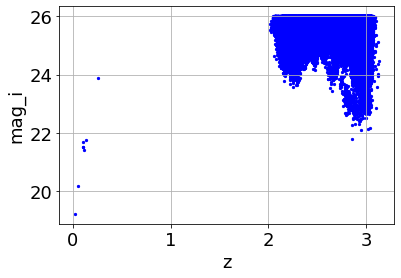

In [247]:
plt.scatter(gal_cat_LBGp['redshift'],gal_cat_LBGp['mag_i_lsst'], s=5, color='blue', label='LBG*')
plt.xlabel('z')
plt.ylabel('mag_i')
plt.grid()

25.499950000000002 3.3193084709750664 \pm 0.07179203715687361 1162.075385376513


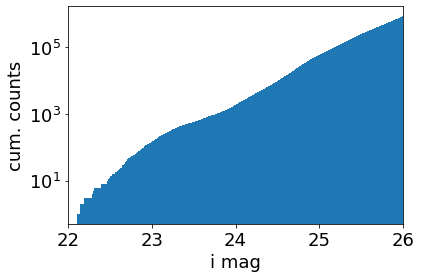

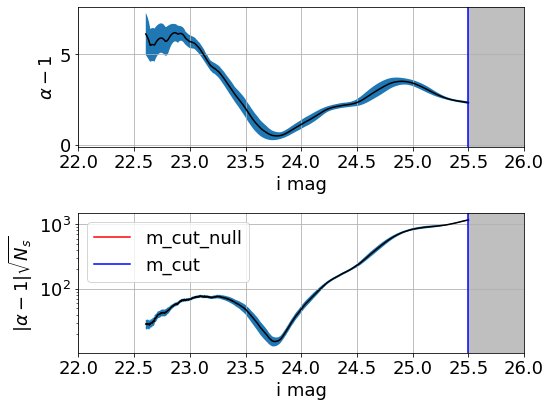

In [254]:
m_cut_LBGp, alpha_cut_LBGp, m_cut_null_LBGp, falpha_LBGp, snr_LBGp, falpha_err_LBGp, snr_err_LBGp, alpha_cut_err_LBGp  = alpha_derivation(gal_cat_LBGp['mag_i_lsst'], 22, 26., binsize, 25.5, show_plots='True')
print(m_cut_LBGp, alpha_cut_LBGp,'\pm',alpha_cut_err_LBGp  ,snr_LBGp[-1])

In [255]:
ind_upp = np.argmax(snr_LBGp + snr_err_LBGp )
ind_low = np.argmax(snr_LBGp - snr_err_LBGp )


falpha_LBGp.x[ind_low], falpha_LBGp.x[ind_upp]

(25.499950000000002, 25.499950000000002)

In [256]:
#correction from 'mag_i_lsst' to 'mag_i_lsst_true' (without lensing)
mu_wl = 1 + 2*gal_cat_LBGp['convergence']
corr_wl = 2.5*np.log10(mu_wl)

25.499950000000002 3.316768102825498


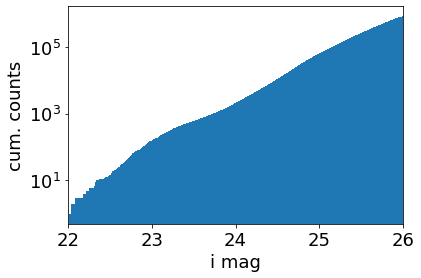

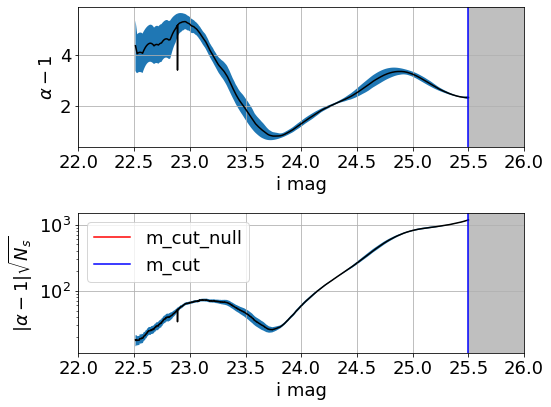

In [257]:
m_cut, alpha_cut, m_cut_null, falpha, snr, falpha_err, snr_err, alpha_cut_err  = alpha_derivation(gal_cat_LBGp['mag_i_lsst']-corr_wl, 22, 26, binsize, 25.5, show_plots='True')
print(m_cut, alpha_cut)

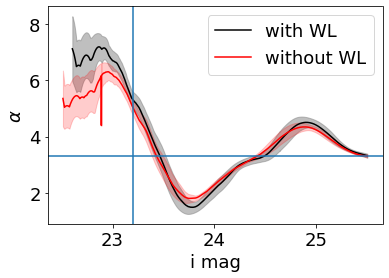

In [258]:
plt.plot(falpha_LBGp.x, falpha_LBGp.y,'k-', label='with WL')
plt.fill_between(falpha_LBGp.x, falpha_LBGp.y - falpha_err_LBGp.y, falpha_LBGp.y + falpha_err_LBGp.y ,color='grey',alpha=0.5)

plt.plot(falpha.x, falpha.y,'r-', label='without WL')
plt.fill_between(falpha.x, falpha.y - falpha_err.y, falpha.y + falpha_err.y ,color='red',alpha=0.2)

plt.axhline(alpha_cut_LBGp)
plt.axvline(23.2)

#plt.ylim(alpha_cut_LBGp-0.02,alpha_cut_LBGp+0.02)

plt.xlabel('i mag')
plt.ylabel('$\\alpha$')
plt.legend()

### = > Minor impact at faint magnitude if we take the magnitude definition with or without weak lensing

## - **LBG** **  ——————————————————————————————————-

In [259]:
gal_cat_LBGpp =  pd.read_hdf(files_path + 'input_data/cat_LBGpp.h5', key='LBGpp')

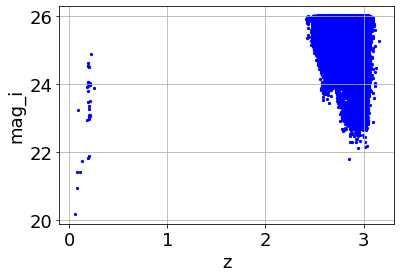

In [260]:
plt.scatter(gal_cat_LBGpp['redshift'],gal_cat_LBGpp['mag_i_lsst'], s=5, color='blue', label='LBG*')
plt.xlabel('z')
plt.ylabel('mag_i')
plt.grid()

25.499950000000002 3.328831816973916 \pm 0.1869358968807298 1033.0646491474479


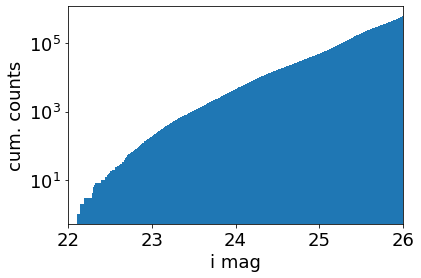

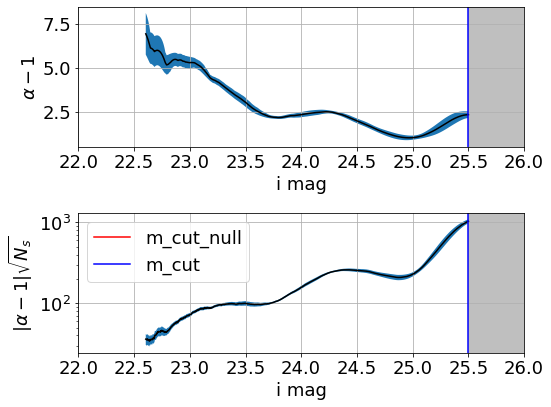

In [261]:
m_cut_LBGpp, alpha_cut_LBGpp, m_cut_null_LBGpp, falpha_LBGpp, snr_LBGpp, falpha_err_LBGpp, snr_err_LBGpp, alpha_cut_err_LBGpp = alpha_derivation(gal_cat_LBGpp['mag_i_lsst'], 22, 26, binsize, 25.5, show_plots='True')
print(m_cut_LBGpp, alpha_cut_LBGpp,'\pm',alpha_cut_err_LBGpp,  snr_LBGpp[-1])

In [263]:
ind_upp = np.argmax(snr_LBGpp + snr_err_LBGpp )
ind_low = np.argmax(snr_LBGpp - snr_err_LBGpp )


falpha_LBGpp.x[ind_low], falpha_LBGpp.x[ind_upp]

(25.499950000000002, 25.499950000000002)

25.495 3.3238981295276693


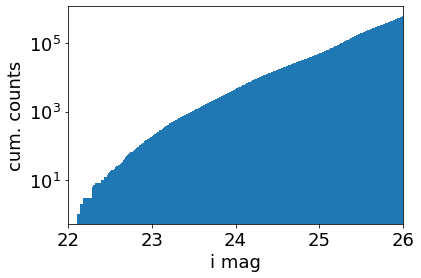

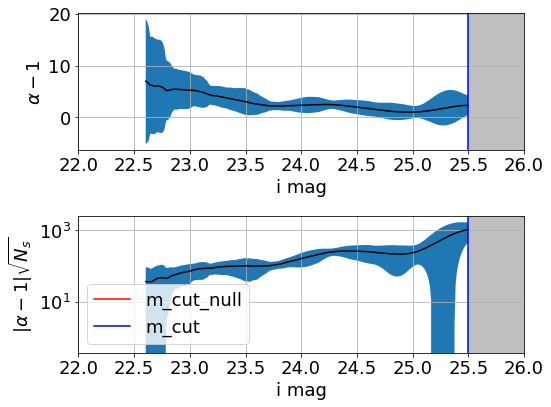

In [264]:
#test impact of low-z interlopers
m_cut1, alpha_cut1, m_cut_null1, falpha1, snr1,  falpha_err_1, snr_err_1, alpha_cut_err_1 = alpha_derivation(gal_cat_LBGpp['mag_i_lsst'][gal_cat_LBGpp['redshift']>1], 22, 26, 0.01, 25.5, show_plots='True')
print(m_cut1, alpha_cut1)

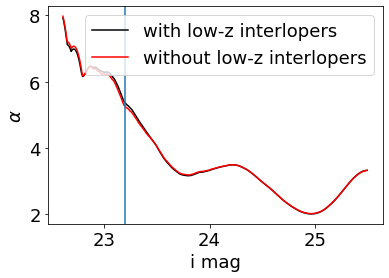

In [265]:
plt.plot(falpha_LBGpp.x, falpha_LBGpp.y,'k-', label='with low-z interlopers')
plt.plot(falpha1.x, falpha1.y,'r-', label='without low-z interlopers')

plt.axvline(23.2)

plt.xlabel('i mag')
plt.ylabel('$\\alpha$')
plt.legend()

### = > No impact from the few low-z interlopers if the histogram starts at the brightest magnitude of the high z sample. 

## - **U-drop** * ——————————————————————————————————-

In [266]:
gal_cat_Udropp =  pd.read_hdf(files_path + 'input_data/cat_Udropp.h5')

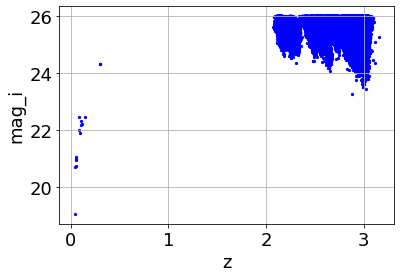

In [267]:
plt.scatter(gal_cat_Udropp['redshift'],gal_cat_Udropp['mag_i_lsst'], s=5, color='blue', label='LBG*')
plt.xlabel('z')
plt.ylabel('mag_i')
plt.grid()

25.499950000000002 4.57596738996398 \pm 0.1345167047279376 924.5172505489927


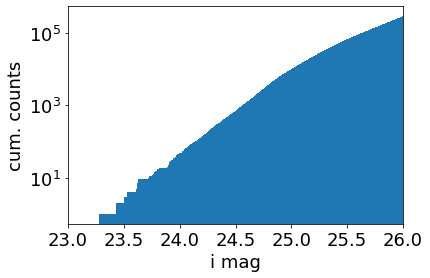

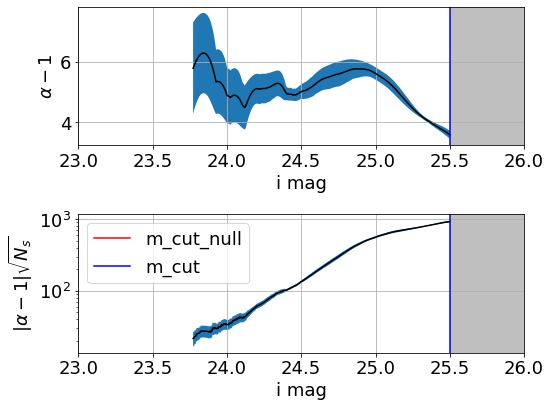

In [268]:
m_cut_Udropp, alpha_cut_Udropp, m_cut_null_Udropp, falpha_Udropp, snr_Udropp,  falpha_err_Udropp, snr_err_Udropp, alpha_cut_err_Udropp  = alpha_derivation(gal_cat_Udropp['mag_i_lsst'], 23, 26, binsize, 25.5, show_plots='True')
print(m_cut_Udropp, alpha_cut_Udropp,'\pm',alpha_cut_err_Udropp, snr_Udropp[-1])

In [269]:
ind_upp = np.argmax(snr_Udropp + snr_err_Udropp)
ind_low = np.argmax(snr_Udropp - snr_err_Udropp)


falpha_Udropp.x[ind_low], falpha_Udropp.x[ind_upp]

(25.499950000000002, 25.499950000000002)

## ——————————————————————————————————

### = > For LBG*, LBG** and U-drop* samples their is no null-count slope in the desired magnitude range. 

In [270]:
conv = (1/(u.deg*u.deg)).to(1/u.arcmin**2)

source_n_LBGp   = len(gal_cat_LBGp['mag_i_lsst']<m_cut_LBGp)
source_n_LBGpp  = len(gal_cat_LBGpp['mag_i_lsst']<m_cut_LBGpp)
source_n_Udropp = len(gal_cat_Udropp['mag_i_lsst']<m_cut_Udropp)

source_dens_LBGp   = source_n_LBGp /(sky_area_cosmoDC2*u.deg*u.deg)
source_dens_LBGpp  = source_n_LBGpp /(sky_area_cosmoDC2*u.deg*u.deg)
source_dens_Udropp = source_n_Udropp /(sky_area_cosmoDC2*u.deg*u.deg)

In [271]:
zmean_LBGp, zmean_err_LBGp = np.mean(gal_cat_LBGp[(gal_cat_LBGp['mag_i_lsst']<m_cut_LBGp)]['redshift']), \
    np.std(gal_cat_LBGp[(gal_cat_LBGp['mag_i_lsst']<m_cut_LBGp)]['redshift'])/np.sqrt(source_n_LBGp)
zmean_LBGpp, zmean_err_LBGpp= np.mean(gal_cat_LBGpp[(gal_cat_LBGpp['mag_i_lsst']<m_cut_LBGpp)]['redshift']),\
    np.std(gal_cat_LBGpp[(gal_cat_LBGpp['mag_i_lsst']<m_cut_LBGpp)]['redshift'])/np.sqrt(source_n_LBGpp)
zmean_Udropp, zmean_err_Udropp = np.mean(gal_cat_Udropp[(gal_cat_Udropp['mag_i_lsst']<m_cut_Udropp)]['redshift']),\
    np.std(gal_cat_Udropp[(gal_cat_Udropp['mag_i_lsst']<m_cut_Udropp)]['redshift'])/np.sqrt(source_n_Udropp)

In [272]:
zmean_err_LBGp, zmean_err_LBGpp, zmean_err_Udropp

(0.0003095435368352518, 0.00016578593712332314, 0.000562273293184341)

In [273]:
#key , m_cut, alpha_cut, m_cut_null

source_sample_properties = np.array([
 ['LBGp',  m_cut_LBGp,   alpha_cut_LBGp,    alpha_cut_err_LBGp,   m_cut_null_LBGp, source_dens_LBGp.value*conv, zmean_LBGp]
,['LBGpp', m_cut_LBGpp,  alpha_cut_LBGpp,  alpha_cut_err_LBGpp,   m_cut_null_LBGpp, source_dens_LBGpp.value*conv, zmean_LBGpp]
,['Udropp',m_cut_Udropp, alpha_cut_Udropp, alpha_cut_err_Udropp,  m_cut_null_Udropp, source_dens_Udropp.value*conv, zmean_Udropp]],dtype=object)


np.save(files_path + "input_data/source_sample_properties.npy", source_sample_properties)

In [274]:
from tabulate import tabulate

heads = ['Sample','mag_cut', 'alpha_cut', 'alpha_cut_err', 'mag_cut_null', 'source density', 'mean z']
print(tabulate(source_sample_properties, headers= heads))
#print(tabulate(source_sample_properties, headers=heads, tablefmt="latex"))

Sample      mag_cut    alpha_cut    alpha_cut_err    mag_cut_null  source density                     mean z
--------  ---------  -----------  ---------------  --------------  -------------------------------  --------
LBGp           25.5      3.31931         0.071792              -1  0.5414024958879886 1 / arcmin2    2.60742
LBGpp          25.5      3.32883         0.186936              -1  0.39203949823687567 1 / arcmin2   2.82556
Udropp         25.5      4.57597         0.134517              -1  0.18094752585475787 1 / arcmin2   2.72526
